# THE MINI FINITE STATE MACHINE: THE COMPLETE FSM BASED ON THE GRAPH FSMver0 #

**The purpose of this code is to create the complete FSM for the Hanoi Droid Capstone.**

_**Main mission: only to test the modules developed**_

**Acknowledge: all the special library makers:**

**https://github.com/pytransitions/transitions**





In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transitions import Machine #libarry used for the state machine
import serial
import serial.tools.list_ports
import speech_recognition as sr
import time

In [2]:
#my custom modules imports
import settingsHD as glb #this import all the global variables
import hanoi_img_procHD as vidpro
import matrix_proc as mtrx
#import statemachine as FSMrobot
import voicerecog as vr
import drawing_frames as draw

In [3]:
ports = serial.tools.list_ports.comports()
serial_inst = serial.Serial()
ports_list = []

for port in ports:
    ports_list.append(str(port))
    print(str(port))

val: str = input('Select Port: COM')


COM7 - Arduino NANO Every (COM7)


Select Port: COM 7


In [4]:
for i in range(len(ports_list)):
    if ports_list[i].startswith(f'COM{val}'):
        port_var = f'COM{val}'
        print(port_var)

serial_inst.baudrate = 115200
serial_inst.port = port_var
serial_inst.open()


COM7


In [5]:
#some global variables
sort_disc_dictionary = {'sort0' : None, 'sort1': None, 'sort2': None}


#variables used for drawing

#states images with theoric matrix
mtx_state_dict = {} #dictionary used to store the images
img_quant = 8  #number of picture states


for i in range (0, (img_quant)):

    name_file = 'DATA/states_img/state' + str(i) + '.jpg'
    name_var = str('state'+str(i))
    mtx_state_dict[name_var] = cv2.imread(name_file)




In [6]:
# this state machine corresponds to all the behaviour of the Hanoi Droid robot, focused on solve the tower of hanoi game.

#from transitions import Machine

class HanoiDroidFSM(object):

    # Define some states. Most of the time, narcoleptic superheroes are just like
    # everyone else. Except for...
    states = ['zero', 'face_track', 'voice_cmd', 'hanoi_game', 'hg_step1', 'hg_step2', 'hg_step3', 'hg_step4', 'hg_step5', 'hg_step6', 'hg_step7', 'game_solved', 'prompt_error'  ]
              
    # A more compact version of the quickstart transitions
    transitions = [{'trigger': 'timer_start_track', 'source': 'zero', 'dest':  'face_track'},
                   {'trigger': 'timer_face_out', 'source': 'face_track', 'dest':  'zero'},
                   {'trigger': 'voice', 'source': 'zero', 'dest':  'voice_cmd', 'before': 'recognize_command'},
                   {'trigger': 'non_command', 'source': 'voice_cmd', 'dest':  'zero'},
                   #{'trigger': 'custom_disc', 'source': 'voice_cmd', 'dest':  'custom_disc'}, future deployment
                   #{'trigger': 'get_mtx', 'source': 'custom_disc', 'dest':  'organize_mov'}, future deployment
                   {'trigger': 'ack', 'source': 'organize_mov', 'dest':  'comp_matrix'},
                   {'trigger': 'eq_mtx', 'source': 'comp_matrix', 'dest':  'game_solved'},
                   {'trigger': 'dif_mtx', 'source': 'comp_matrix', 'dest':  'prompt_error'},
                   {'trigger': 'solve_hanoi', 'source': 'voice_cmd', 'dest':  'hanoi_game'},
                   {'trigger': 'hg_start', 'source': 'hanoi_game', 'dest':  'hg_step1', 'before': 'serial_cmd_step1'},
                   {'trigger': 'ack', 'source': 'hg_step1', 'dest':  'hg_step2', 'before': 'serial_cmd_step2'},
                   {'trigger': 'ack', 'source': 'hg_step2', 'dest':  'hg_step3', 'before': 'serial_cmd_step3'},
                   {'trigger': 'ack', 'source': 'hg_step3', 'dest':  'hg_step4', 'before': 'serial_cmd_step4'},
                   {'trigger': 'ack', 'source': 'hg_step4', 'dest':  'hg_step5', 'before': 'serial_cmd_step5'},
                   {'trigger': 'ack', 'source': 'hg_step5', 'dest':  'hg_step6', 'before': 'serial_cmd_step6'},
                   {'trigger': 'ack', 'source': 'hg_step6', 'dest':  'hg_step7', 'before': 'serial_cmd_step7'},
                   {'trigger': 'dif_mtx', 'source': 'hanoi_game', 'dest':  'prompt_error'},
                   {'trigger': 'dif_mtx', 'source': 'hg_step1', 'dest':  'prompt_error', 'before': 'serial_cmd_rest'},
                   {'trigger': 'dif_mtx', 'source': 'hg_step2', 'dest':  'prompt_error', 'before': 'serial_cmd_rest'},
                   {'trigger': 'dif_mtx', 'source': 'hg_step3', 'dest':  'prompt_error', 'before': 'serial_cmd_rest'},
                   {'trigger': 'dif_mtx', 'source': 'hg_step4', 'dest':  'prompt_error', 'before': 'serial_cmd_rest'},
                   {'trigger': 'dif_mtx', 'source': 'hg_step5', 'dest':  'prompt_error', 'before': 'serial_cmd_rest'},
                   {'trigger': 'dif_mtx', 'source': 'hg_step6', 'dest':  'prompt_error', 'before': 'serial_cmd_rest'},
                   {'trigger': 'dif_mtx', 'source': 'hg_step7', 'dest':  'prompt_error', 'before': 'serial_cmd_rest'},
                   {'trigger': 'ack', 'source': 'hg_step7', 'dest':  'game_solved', 'before': 'serial_cmd_rest'},
                   {'trigger': 'timer_show', 'source': 'game_solved', 'dest':  'zero'},
                   {'trigger': 'timer_show', 'source': 'prompt_error', 'dest':  'zero'}]
    
    
    
    def __init__(self, name):

        self.name = name
        #self.kittens_rescued = 0  # What have we accomplished today?
        self.command = 'none'
       
        # Initialize the state machine
        self.machine = Machine(model=self, states=HanoiDroidFSM.states,
                               transitions=HanoiDroidFSM.transitions, initial='zero')
        
            
    
    def recognize_command(self):
        print("I am in Voice state")
        
    def serial_cmd_step1(self):
        command = 'a'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(25)
       
    def serial_cmd_step2(self):
        command = 'b'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(25)
        
    def serial_cmd_step3(self):
        command = 'c'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(25)

    def serial_cmd_step4(self):
        command = 'd'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(25)
        
    def serial_cmd_step5(self):
        command = 'e'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(25)

    def serial_cmd_step6(self):
        command = 'f'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(25)
         
    def serial_cmd_step7(self):
        command = 'g'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(25)
        
    def serial_cmd_rest(self):
        command = 'R'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(10)
        
        

In [7]:
    # Load four images
image1 = cv2.imread('DATA/states_img/nomatch.png')
image2 = cv2.imread('DATA/intro_image/intro2.png')
image3 = cv2.imread('DATA/intro_image/intro3.png')
image4 = cv2.imread('DATA/intro_image/intro4.png')

    # Create a 2x2 matrix with the images
top_row = np.hstack((image1, image2))
bottom_row = np.hstack((image3, image4))
result = np.vstack((top_row, bottom_row))

    # Display the frame with the four images
cv2.imshow('MainFrame', result)
cv2.waitKey(1)
            

-1

In [17]:
cv2.destroyAllWindows()

In [7]:
#create the state machine object

#droid = FSMrobot.HanoiDroidFSM("Droid") remove comment for final
droid = HanoiDroidFSM("Droid")



In [8]:
while droid.state == 'zero':
    
    window = draw.draw_intro()
    # Display the frame with the four images
    cv2.imshow('MainWindow', window)
    cv2.waitKey(1)
    
    print ("inside zero state")
    have_a_command, command = vr.start_robot_voice_command()
    if have_a_command:
        droid.voice()
        break


inside zero state
Listening for 'robot start' command...
result2:
{   'alternative': [   {'confidence': 0.94181472, 'transcript': 'start'},
                       {'confidence': 0.94181472, 'transcript': 'starte'},
                       {'confidence': 0.9418146, 'transcript': 'startt'}],
    'final': True}
I am in Voice state


In [9]:
if droid.state == 'voice_cmd':
    if "start" in command:
        print("Starting the hanoi solving...")
        droid.solve_hanoi()
    else:
        print("command not in my instructions")
        droid.non_command()

Starting the hanoi solving...


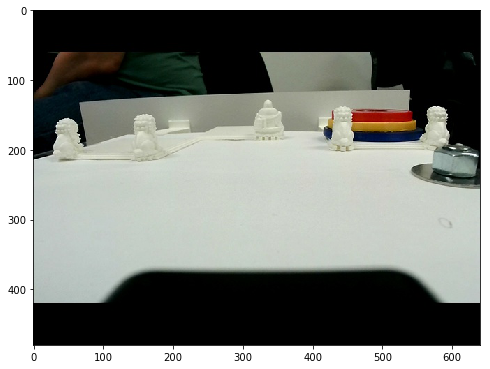

In [10]:
####------------DELETE THIS FOR THE FINAL IMPLEMENTATION----------------------------
# load the dictionary with the jpg dataset stored at DATA


def display(img, cmap='gray'):
    fig = plt.figure(figsize = (8,9))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    
    

hanoi_dict = {} #dictionary used to store the images
img_quant = 21  #number of samples pictures


for i in range (1, (img_quant+1)):

    
    #note: the files from 18 nov are the ones without the withe background
    #name_file = 'DATA/CamosunTest/hanoinov18sample (' + str(i) + ').jpg'
    name_file = 'DATA/CamosunTest/hanoinov24sample (' + str(i) + ').jpg'
    name_var = str('hanoi'+str(i))
    
    hanoi_dict[name_var] = cv2.imread(name_file)

#load the image that I want to know the HSV value, but first look in the RGB version and also get the HSV version

img = hanoi_dict['hanoi2']
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
imagecopy = image.copy()
imagehsvcopy = imagehsv.copy()
display(image)

small_image_hsv = imagehsvcopy[130:230, 0:630]



#####------DELETE ABOVE !!!!!----###############-

inside hanoi_game state


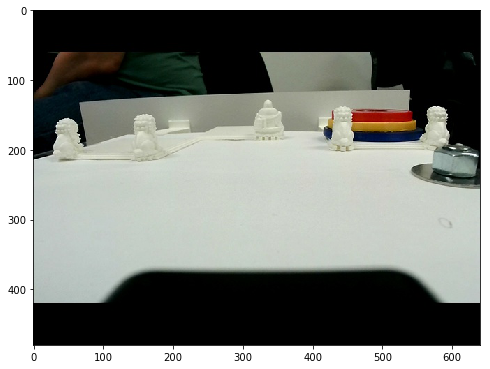

In [11]:
if droid.state == 'hanoi_game':
    print ("inside hanoi_game state")
    
    #--------- UNCOMMENT FOR FINAL APPLICATION
    #frame = vidpro.take_one_frame() #this is to take the picture of the outside. I should compare to the inital state
    #small_image_hsv = vidpro.convert_and_crop(frame)
    
    
        #--------- delete below------------**********
    img = hanoi_dict['hanoi2']
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    imagehsvcopy = imagehsv.copy()
    display(image)

    small_image_hsv = imagehsvcopy[130:230, 0:630]
    #---delete above----------********************
    
    
    #pilas: cuando se trabaje con el definitivo, tengo que cambiar el nombre de imagecopy por el de frame
    for i in range (0, 3):
        image2 = cv2.rectangle(imagecopy, (glb.mask_x_position_dict['x'+str(i)], glb.mask_y_position_dict['y'+str(i)]+130), ((glb.mask_x_position_dict['x'+str(i)] + glb.mask_width), (glb.mask_y_position_dict['y'+str(i)]+glb.mask_height+130)), (0,0,255), thickness = 2)
  
    frame3 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    
    #display(image2)
    
    for i in range(0, 3):
        imagehsv_roi = small_image_hsv[glb.mask_y_position_dict['y'+str(i)]:(glb.mask_y_position_dict['y'+str(i)] + glb.mask_height), int(glb.mask_x_position_dict['x'+str(i)]):int(glb.mask_x_position_dict['x'+str(i)]+glb.mask_width)]
        #display(imagehsv_roi)
        sort_disc_dictionary['sort' + str(i)] = vidpro.detect_color(imagehsv_roi) 
    
    state = 0
    frame2 = mtx_state_dict['state' + str(state)]
    #hanoi_mat= glb.hanoi_matrix_char[(3*state):(3*(state+1)), :] #this is the theorical correct matrix
    detected_matrix_char = mtrx.get_detected_matrix_char(sort_disc_dictionary) #this is the matrix detected by the camera
    frame1 = draw.write_in_image(image2,detected_matrix_char) #write the letters of the detected matrix
    #flip_detected_matrix_char = np.fliplr(detected_matrix_char) #need to flip to adjust user/robot perspective
    matrices_are_equal = mtrx.compare_matrix (detected_matrix_char, state)
    
    #display(image_with_letters)
    
    if matrices_are_equal: #if the matrices are equal, continues next state, if not, go to prompt error
        frame4 = cv2.imread('DATA/states_img/match.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(6) #time to show and explain
        command = 'S'
        serial_inst.write(command.encode('utf-8'))
        time.sleep(3) #give time to raise the hand
        droid.hg_start()
    
    else:
        frame4 = cv2.imread('DATA/states_img/nomatch.png')    
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)        
        time.sleep(6)
        droid.dif_mtx()
        


In [12]:
droid.state

'hg_step1'

inside step1 state


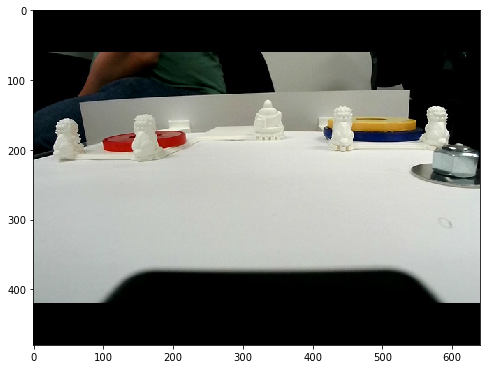

In [13]:
if droid.state == 'hg_step1':
    print ("inside step1 state")
    
    #--------- UNCOMMENT FOR FINAL APPLICATION
    #frame = vidpro.take_one_frame() #this is to take the picture of the outside. I should compare to the inital state
    #small_image_hsv = vidpro.convert_and_crop(frame)
    
    #--------- delete below------------**********
    img = hanoi_dict['hanoi3']
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    imagehsvcopy = imagehsv.copy()
    display(image)

    small_image_hsv = imagehsvcopy[130:230, 0:630]
    #---delete above----------********************
    
    
    #pilas: cuando se trabaje con el definitivo, tengo que cambiar el nombre de imagecopy por el de frame
    for i in range (0, 3):
        image2 = cv2.rectangle(imagecopy, (glb.mask_x_position_dict['x'+str(i)], glb.mask_y_position_dict['y'+str(i)]+130), ((glb.mask_x_position_dict['x'+str(i)] + glb.mask_width), (glb.mask_y_position_dict['y'+str(i)]+glb.mask_height+130)), (0,0,255), thickness = 2)
  
    frame3 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    
    #display(image2)
    
    for i in range(0, 3):
        imagehsv_roi = small_image_hsv[glb.mask_y_position_dict['y'+str(i)]:(glb.mask_y_position_dict['y'+str(i)] + glb.mask_height), int(glb.mask_x_position_dict['x'+str(i)]):int(glb.mask_x_position_dict['x'+str(i)]+glb.mask_width)]
        #display(imagehsv_roi)
        sort_disc_dictionary['sort' + str(i)] = vidpro.detect_color(imagehsv_roi) 
    
    state = 1  #this variable change every time based on the state that is inside  
    frame2 = mtx_state_dict['state' + str(state)]
    detected_matrix_char = mtrx.get_detected_matrix_char(sort_disc_dictionary) #this is the matrix detected by the camera
    frame1 = draw.write_in_image(image2,detected_matrix_char) #write the letters of the detected matrix
    matrices_are_equal = mtrx.compare_matrix (detected_matrix_char, state)
    
    #display(image_with_letters)
    
    if matrices_are_equal: #if the matrices are equal, continues next state, if not, go to prompt error
        frame4 = cv2.imread('DATA/states_img/match.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(10) #time to show and explain
        droid.ack()
    else:
        
        frame4 = cv2.imread('DATA/states_img/nomatch.png')    
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(4) #time to show and explain
        droid.dif_mtx()
 

inside step2 state


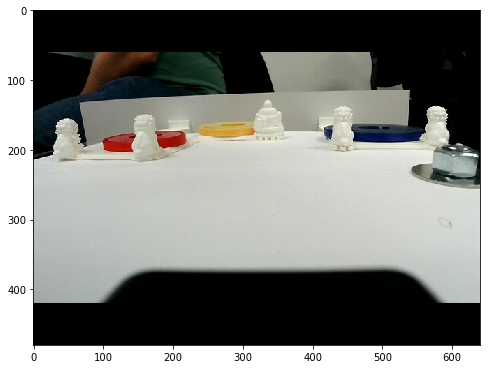

In [14]:
if droid.state == 'hg_step2':
    print ("inside step2 state")
    
    #--------- UNCOMMENT FOR FINAL APPLICATION
    #frame = vidpro.take_one_frame() #this is to take the picture of the outside. I should compare to the inital state
    #small_image_hsv = vidpro.convert_and_crop(frame)
    
    #--------- delete below------------**********
    img = hanoi_dict['hanoi4']
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    imagehsvcopy = imagehsv.copy()
    display(image)

    small_image_hsv = imagehsvcopy[130:230, 0:630]
    #---delete above----------********************
    
    
    #pilas: cuando se trabaje con el definitivo, tengo que cambiar el nombre de imagecopy por el de frame
    for i in range (0, 3):
        image2 = cv2.rectangle(imagecopy, (glb.mask_x_position_dict['x'+str(i)], glb.mask_y_position_dict['y'+str(i)]+130), ((glb.mask_x_position_dict['x'+str(i)] + glb.mask_width), (glb.mask_y_position_dict['y'+str(i)]+glb.mask_height+130)), (0,0,255), thickness = 2)
  
    frame3 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    
    #display(image2)
    
    for i in range(0, 3):
        imagehsv_roi = small_image_hsv[glb.mask_y_position_dict['y'+str(i)]:(glb.mask_y_position_dict['y'+str(i)] + glb.mask_height), int(glb.mask_x_position_dict['x'+str(i)]):int(glb.mask_x_position_dict['x'+str(i)]+glb.mask_width)]
        #display(imagehsv_roi)
        sort_disc_dictionary['sort' + str(i)] = vidpro.detect_color(imagehsv_roi) 
    
    state = 2  #this variable change every time based on the state that is inside  
    frame2 = mtx_state_dict['state' + str(state)]
    detected_matrix_char = mtrx.get_detected_matrix_char(sort_disc_dictionary) #this is the matrix detected by the camera
    frame1 = draw.write_in_image(image2,detected_matrix_char) #write the letters of the detected matrix
    matrices_are_equal = mtrx.compare_matrix (detected_matrix_char, state)
    
    #display(image_with_letters)
    
    if matrices_are_equal: #if the matrices are equal, continues next state, if not, go to prompt error
        frame4 = cv2.imread('DATA/states_img/match.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(5) #time to show and explain
        droid.ack()
    else:
        
        frame4 = cv2.imread('DATA/states_img/nomatch.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(4) #time to show and explain
        droid.dif_mtx()


inside step3 state


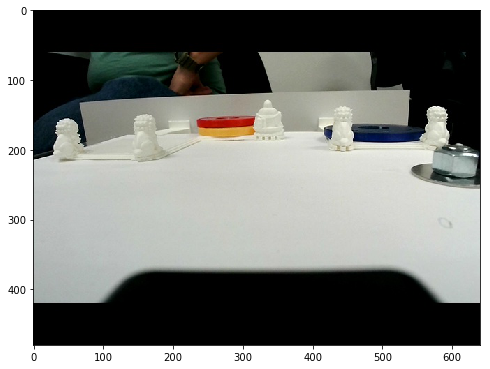

In [15]:
if droid.state == 'hg_step3':
    print ("inside step3 state")
    
    #--------- UNCOMMENT FOR FINAL APPLICATION
    #frame = vidpro.take_one_frame() #this is to take the picture of the outside. I should compare to the inital state
    #small_image_hsv = vidpro.convert_and_crop(frame)
    
    #--------- delete below------------**********
    img = hanoi_dict['hanoi5']
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    imagehsvcopy = imagehsv.copy()
    display(image)

    small_image_hsv = imagehsvcopy[130:230, 0:630]
    #---delete above----------********************
    
    
    #pilas: cuando se trabaje con el definitivo, tengo que cambiar el nombre de imagecopy por el de frame
    for i in range (0, 3):
        image2 = cv2.rectangle(imagecopy, (glb.mask_x_position_dict['x'+str(i)], glb.mask_y_position_dict['y'+str(i)]+130), ((glb.mask_x_position_dict['x'+str(i)] + glb.mask_width), (glb.mask_y_position_dict['y'+str(i)]+glb.mask_height+130)), (0,0,255), thickness = 2)
  
    frame3 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    
    #display(image2)
    
    for i in range(0, 3):
        imagehsv_roi = small_image_hsv[glb.mask_y_position_dict['y'+str(i)]:(glb.mask_y_position_dict['y'+str(i)] + glb.mask_height), int(glb.mask_x_position_dict['x'+str(i)]):int(glb.mask_x_position_dict['x'+str(i)]+glb.mask_width)]
        #display(imagehsv_roi)
        sort_disc_dictionary['sort' + str(i)] = vidpro.detect_color(imagehsv_roi) 
    
    state = 3  #this variable change every time based on the state that is inside  
    frame2 = mtx_state_dict['state' + str(state)]
    detected_matrix_char = mtrx.get_detected_matrix_char(sort_disc_dictionary) #this is the matrix detected by the camera
    frame1 = draw.write_in_image(image2,detected_matrix_char) #write the letters of the detected matrix
    matrices_are_equal = mtrx.compare_matrix (detected_matrix_char, state)
    
    #display(image_with_letters)
    
    if matrices_are_equal: #if the matrices are equal, continues next state, if not, go to prompt error
        frame4 = cv2.imread('DATA/states_img/match.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(2) #time to show and explain
        droid.ack()
    else:
        
        frame4 = cv2.imread('DATA/states_img/nomatch.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(4) #time to show and explain
        droid.dif_mtx()


inside step4 state


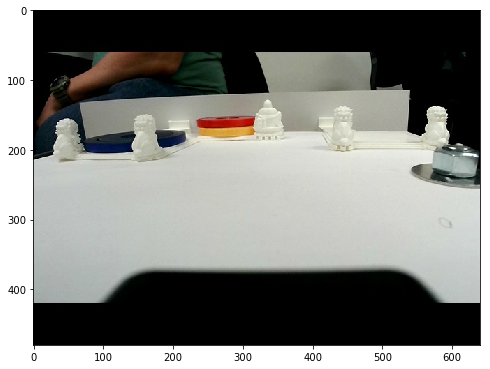

In [16]:
if droid.state == 'hg_step4':
    print ("inside step4 state")
    
    #--------- UNCOMMENT FOR FINAL APPLICATION
    #frame = vidpro.take_one_frame() #this is to take the picture of the outside. I should compare to the inital state
    #small_image_hsv = vidpro.convert_and_crop(frame)
    
    #--------- delete below------------**********
    img = hanoi_dict['hanoi6']
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    imagehsvcopy = imagehsv.copy()
    display(image)

    small_image_hsv = imagehsvcopy[130:230, 0:630]
    #---delete above----------********************
    
    
    #pilas: cuando se trabaje con el definitivo, tengo que cambiar el nombre de imagecopy por el de frame
    for i in range (0, 3):
        image2 = cv2.rectangle(imagecopy, (glb.mask_x_position_dict['x'+str(i)], glb.mask_y_position_dict['y'+str(i)]+130), ((glb.mask_x_position_dict['x'+str(i)] + glb.mask_width), (glb.mask_y_position_dict['y'+str(i)]+glb.mask_height+130)), (0,0,255), thickness = 2)
  
    frame3 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    
    #display(image2)
    
    for i in range(0, 3):
        imagehsv_roi = small_image_hsv[glb.mask_y_position_dict['y'+str(i)]:(glb.mask_y_position_dict['y'+str(i)] + glb.mask_height), int(glb.mask_x_position_dict['x'+str(i)]):int(glb.mask_x_position_dict['x'+str(i)]+glb.mask_width)]
        #display(imagehsv_roi)
        sort_disc_dictionary['sort' + str(i)] = vidpro.detect_color(imagehsv_roi) 
    
    state = 4  #this variable change every time based on the state that is inside  
    frame2 = mtx_state_dict['state' + str(state)]
    detected_matrix_char = mtrx.get_detected_matrix_char(sort_disc_dictionary) #this is the matrix detected by the camera
    frame1 = draw.write_in_image(image2,detected_matrix_char) #write the letters of the detected matrix
    matrices_are_equal = mtrx.compare_matrix (detected_matrix_char, state)
    
    #display(image_with_letters)
    
    if matrices_are_equal: #if the matrices are equal, continues next state, if not, go to prompt error
        frame4 = cv2.imread('DATA/states_img/match.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(2) #time to show and explain
        droid.ack()
    else:
        
        frame4 = cv2.imread('DATA/states_img/nomatch.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(4) #time to show and explain
        droid.dif_mtx()


inside step5 state


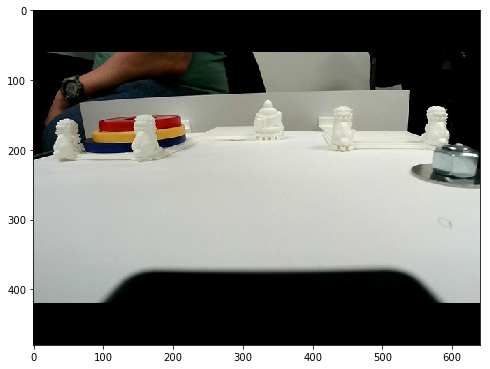

In [18]:
if droid.state == 'hg_step5':
    print ("inside step5 state")
    
    #--------- UNCOMMENT FOR FINAL APPLICATION
    #frame = vidpro.take_one_frame() #this is to take the picture of the outside. I should compare to the inital state
    #small_image_hsv = vidpro.convert_and_crop(frame)
    
    #--------- delete below------------**********
    img = hanoi_dict['hanoi7']
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    imagehsvcopy = imagehsv.copy()
    display(image)

    small_image_hsv = imagehsvcopy[130:230, 0:630]
    #---delete above----------********************
    
    
    #pilas: cuando se trabaje con el definitivo, tengo que cambiar el nombre de imagecopy por el de frame
    for i in range (0, 3):
        image2 = cv2.rectangle(imagecopy, (glb.mask_x_position_dict['x'+str(i)], glb.mask_y_position_dict['y'+str(i)]+130), ((glb.mask_x_position_dict['x'+str(i)] + glb.mask_width), (glb.mask_y_position_dict['y'+str(i)]+glb.mask_height+130)), (0,0,255), thickness = 2)
  
    frame3 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    
    #display(image2)
    
    for i in range(0, 3):
        imagehsv_roi = small_image_hsv[glb.mask_y_position_dict['y'+str(i)]:(glb.mask_y_position_dict['y'+str(i)] + glb.mask_height), int(glb.mask_x_position_dict['x'+str(i)]):int(glb.mask_x_position_dict['x'+str(i)]+glb.mask_width)]
        #display(imagehsv_roi)
        sort_disc_dictionary['sort' + str(i)] = vidpro.detect_color(imagehsv_roi) 
    
    state = 5  #this variable change every time based on the state that is inside  
    frame2 = mtx_state_dict['state' + str(state)]
    detected_matrix_char = mtrx.get_detected_matrix_char(sort_disc_dictionary) #this is the matrix detected by the camera
    frame1 = draw.write_in_image(image2,detected_matrix_char) #write the letters of the detected matrix
    matrices_are_equal = mtrx.compare_matrix (detected_matrix_char, state)
    #display(image_with_letters)
    
    if matrices_are_equal: #if the matrices are equal, continues next state, if not, go to prompt error
        frame4 = cv2.imread('DATA/states_img/match.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(2) #time to show and explain
        droid.ack()
    else:
        
        frame4 = cv2.imread('DATA/states_img/nomatch.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(4) #time to show and explain
        droid.dif_mtx()

inside step6 state


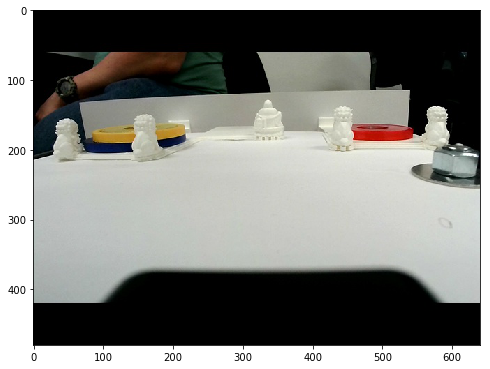

In [41]:
if droid.state == 'hg_step6':
    print ("inside step6 state")
    
    #--------- UNCOMMENT FOR FINAL APPLICATION
    #frame = vidpro.take_one_frame() #this is to take the picture of the outside. I should compare to the inital state
    #small_image_hsv = vidpro.convert_and_crop(frame)
    
    #--------- delete below------------**********
    img = hanoi_dict['hanoi8']
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    imagehsvcopy = imagehsv.copy()
    display(image)

    small_image_hsv = imagehsvcopy[130:230, 0:630]
    #---delete above----------********************
    
    
    #pilas: cuando se trabaje con el definitivo, tengo que cambiar el nombre de imagecopy por el de frame
    for i in range (0, 3):
        image2 = cv2.rectangle(imagecopy, (glb.mask_x_position_dict['x'+str(i)], glb.mask_y_position_dict['y'+str(i)]+130), ((glb.mask_x_position_dict['x'+str(i)] + glb.mask_width), (glb.mask_y_position_dict['y'+str(i)]+glb.mask_height+130)), (0,0,255), thickness = 2)
  
    frame3 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    
    #display(image2)
    
    for i in range(0, 3):
        imagehsv_roi = small_image_hsv[glb.mask_y_position_dict['y'+str(i)]:(glb.mask_y_position_dict['y'+str(i)] + glb.mask_height), int(glb.mask_x_position_dict['x'+str(i)]):int(glb.mask_x_position_dict['x'+str(i)]+glb.mask_width)]
        #display(imagehsv_roi)
        sort_disc_dictionary['sort' + str(i)] = vidpro.detect_color(imagehsv_roi) 
    
    state = 6  #this variable change every time based on the state that is inside  
    frame2 = mtx_state_dict['state' + str(state)]
    detected_matrix_char = mtrx.get_detected_matrix_char(sort_disc_dictionary) #this is the matrix detected by the camera
    frame1 = draw.write_in_image(image2,detected_matrix_char) #write the letters of the detected matrix
    matrices_are_equal = mtrx.compare_matrix (detected_matrix_char, state)
    
    #display(image_with_letters)
    
    if matrices_are_equal: #if the matrices are equal, continues next state, if not, go to prompt error
        frame4 = cv2.imread('DATA/states_img/match.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(2) #time to show and explain
        droid.ack()
    else:
        
        frame4 = cv2.imread('DATA/states_img/nomatch.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(4) #time to show and explain
        droid.dif_mtx()


inside step7 state


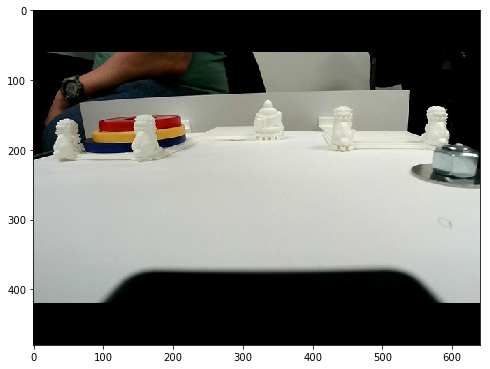

In [42]:
if droid.state == 'hg_step7':
    print ("inside step7 state")
    
    #--------- UNCOMMENT FOR FINAL APPLICATION
    #frame = vidpro.take_one_frame() #this is to take the picture of the outside. I should compare to the inital state
    #small_image_hsv = vidpro.convert_and_crop(frame)
    
    #--------- delete below------------**********
    img = hanoi_dict['hanoi9']
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imagecopy = image.copy()
    imagehsvcopy = imagehsv.copy()
    display(image)

    small_image_hsv = imagehsvcopy[130:230, 0:630]
    #---delete above----------********************
    
    
    #pilas: cuando se trabaje con el definitivo, tengo que cambiar el nombre de imagecopy por el de frame
    for i in range (0, 3):
        image2 = cv2.rectangle(imagecopy, (glb.mask_x_position_dict['x'+str(i)], glb.mask_y_position_dict['y'+str(i)]+130), ((glb.mask_x_position_dict['x'+str(i)] + glb.mask_width), (glb.mask_y_position_dict['y'+str(i)]+glb.mask_height+130)), (0,0,255), thickness = 2)
  
    frame3 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
    
    #display(image2)
    
    for i in range(0, 3):
        imagehsv_roi = small_image_hsv[glb.mask_y_position_dict['y'+str(i)]:(glb.mask_y_position_dict['y'+str(i)] + glb.mask_height), int(glb.mask_x_position_dict['x'+str(i)]):int(glb.mask_x_position_dict['x'+str(i)]+glb.mask_width)]
        #display(imagehsv_roi)
        sort_disc_dictionary['sort' + str(i)] = vidpro.detect_color(imagehsv_roi) 
    
    state = 7  #this variable change every time based on the state that is inside  
    frame2 = mtx_state_dict['state' + str(state)]
    detected_matrix_char = mtrx.get_detected_matrix_char(sort_disc_dictionary) #this is the matrix detected by the camera
    frame1 = draw.write_in_image(image2,detected_matrix_char) #write the letters of the detected matrix
    matrices_are_equal = mtrx.compare_matrix (detected_matrix_char, state)
    
    #display(image_with_letters)
    
    if matrices_are_equal: #if the matrices are equal, continues next state, if not, go to prompt error
        frame4 = cv2.imread('DATA/states_img/match.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(2) #time to show and explain
        droid.ack()
    else:
        
        frame4 = cv2.imread('DATA/states_img/nomatch.png')
        window = draw.draw_matrix(frame1,frame2,frame3,frame4)
        cv2.imshow('MainWindow', window)
        cv2.waitKey(1)
        time.sleep(4) #time to show and explain
        droid.dif_mtx()


In [19]:
if droid.state == 'prompt_error':
    print ("inside the error prompt state")
    window = draw.draw_error()
    cv2.imshow('MainWindow', window)
    cv2.waitKey(1)
    time.sleep(5)
    droid.timer_show()



inside the error prompt state


In [43]:
if droid.state == 'game_solved':
    print ("inside the error prompt state")
    window =  draw.draw_solved()
    cv2.imshow('MainWindow', window)
    cv2.waitKey(1)
    time.sleep(5)
    droid.timer_show()


inside the error prompt state


In [20]:
flip_detected_matrix_char

array([['R', '0', '0'],
       ['Y', '0', '0'],
       ['B', '0', '0']], dtype='<U1')

In [21]:
 hanoi_mat

array([['R', '0', '0'],
       ['Y', '0', '0'],
       ['B', '0', '0']], dtype='<U1')

In [18]:
serial_inst.open()
command = 'a'
serial_inst.write(command.encode('utf-8'))

SerialException: Port is already open.

In [22]:
matrices_are_equal

True

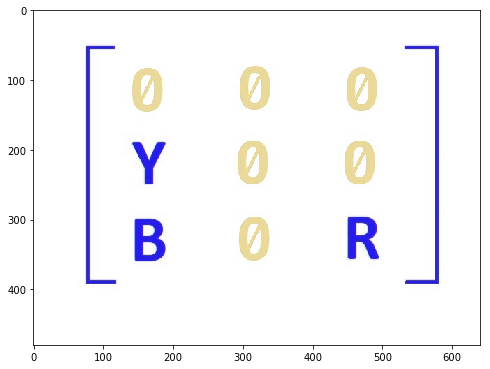

In [28]:
display(mtx_state_dict['state1'])

In [24]:
frame = mtx_state_dict['state1']

In [25]:
 cv2.imshow('MainFrame', frame)

error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\highgui\src\window.cpp:356: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [21]:
len(mtx_state_dict)

8

In [26]:
frame